# Insatalling MNE library and Loading the data with wget

In [8]:
%%capture
!pip install mne
!wget -r -N -c -np https://physionet.org/files/eegmat/1.0.0/

# Importing Necessary Libraries

In [9]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Loading Data Paths

In [10]:
num_subjects = 36

# Change Path According to the location.
file_path_template = '/kaggle/working/physionet.org/files/eegmat/1.0.0/Subject{subject_number:02d}_{recording_type}.edf'
# file_path_template = '/content/physionet.org/files/eegmat/1.0.0/Subject{subject_number:02d}_{recording_type}.edf'

# Function to generate file paths
def get_file_paths(num_subjects, file_path_template):
    file_paths = []
    for subject_number in range(num_subjects):
        for recording_type in [1, 2]:  # 1 for rest, 2 for task
            file_path = file_path_template.format(subject_number=subject_number, recording_type=recording_type)
            file_paths.append((subject_number, recording_type, file_path))
    return file_paths

file_paths = get_file_paths(num_subjects, file_path_template)

# PSD Analysis

In [54]:
%%capture

import mne
import os

# Function to load EDF files
def load_eeg_data(subject_id, condition):
    file_path = f'/kaggle/working/physionet.org/files/eegmat/1.0.0/Subject{subject_id:02d}_{condition}.edf'
    raw = mne.io.read_raw_edf(file_path, preload=True)
    return raw

# Load data for all subjects
rest_data = [load_eeg_data(i, 1) for i in range(36)]
task_data = [load_eeg_data(i, 2) for i in range(36)]


In [34]:
len(rest_data) , len(task_data)

(36, 36)

In [ ]:
# bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}


In [121]:

def calculate_band_means(df_list):
    # Define frequency bands
    bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}
    
    # Initialize dictionary to store mean values for each band
    band_means = {band: [] for band in bands}
    
    # Loop through each dataframe
    for rdf in df_list:
        # Calculate mean for each dataframe except 'freq'
        df = rdf.compute_psd().to_data_frame()
        averaged_data = df.drop(columns=['freq']).mean(axis =1)
        
        # Calculate mean for each band within averaged_data
        for band_name, (low, high) in bands.items():
            band_data = averaged_data[(df['freq'] >= low) & (df['freq'] < high)]
            mean_value = band_data.mean()
            
            # Append mean value to the corresponding band list
            band_means[band_name].append(mean_value)
    
    return band_means




In [115]:
%%capture
rest_data_bands = calculate_band_means(rest_data)
task_data_bands = calculate_band_means(task_data)

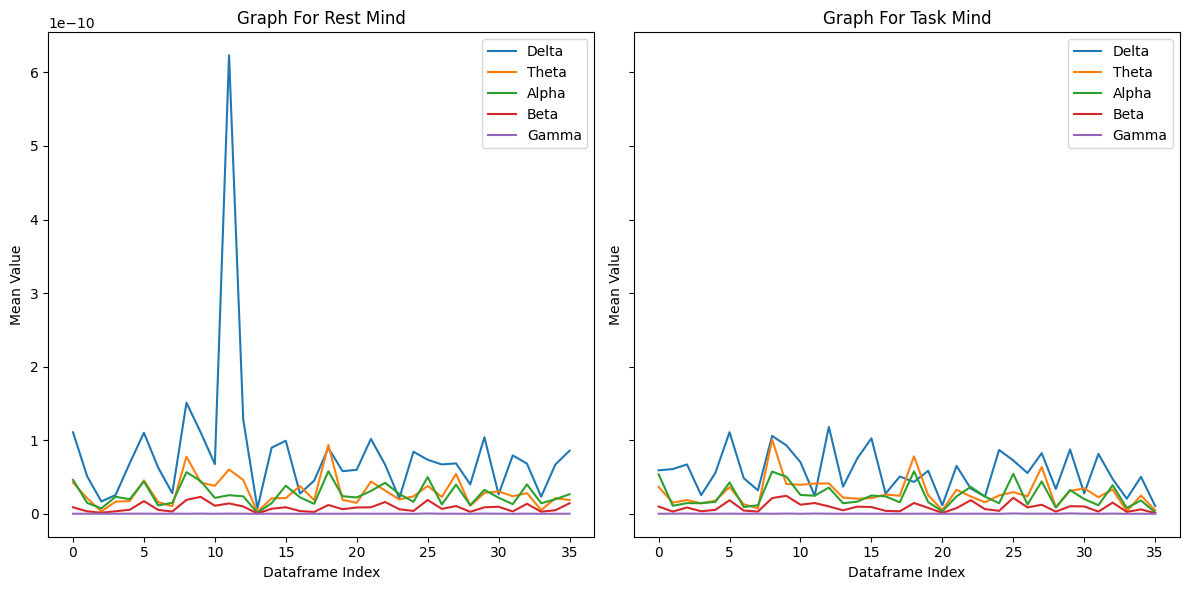

In [119]:
import matplotlib.pyplot as plt

def plot_band_means(band_means_dict1, band_means_dict2):
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    
    # Create figure and axes for subplots, sharing y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Plot for first dictionary
    for band in bands:
        ax1.plot(band_means_dict1[band], label=band)
    ax1.set_xlabel('Dataframe Index')
    ax1.set_ylabel('Mean Value')
    ax1.set_title('Graph For Rest Mind')
    ax1.legend()
    
    # Plot for second dictionary
    for band in bands:
        ax2.plot(band_means_dict2[band], label=band)
    ax2.set_xlabel('Dataframe Index')
    ax2.set_ylabel('Mean Value')
    ax2.set_title('Graph For Task Mind')
    ax2.legend()
    
    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()


plot_band_means(rest_data_bands, task_data_bands)


**Both States Look Similar, although while performing task delta waves are less and more consistent.
Where while resting these waves are fluctuating.**

### Helper Functions

In [11]:
%%capture
# Function to load and preprocess a single file
def load_and_preprocess(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.set_eeg_reference()
    epochs = mne.make_fixed_length_epochs(raw, duration=60)
    raw = epochs.average()
    raw = raw.get_data()
    return raw

# Dictionary to store raw data for each subject and recording type
raw_data = {}

for subject_number, recording_type, file_path in file_paths:
    raw = load_and_preprocess(file_path)
    raw_data[(subject_number, recording_type)] = raw


In [12]:
def get_data_matrix(raw_data):
  values_list = list(raw_data.values())

  # Step 2: Stack the values into a single NumPy array
  stacked_array = np.stack(values_list)

  # Step 3: Reshape the array to the desired dimensions (32, 1, 21, 30000)
  reshaped_array = stacked_array[:, np.newaxis, :, :]

  # Print the shape to verify
  return(reshaped_array)

In [13]:
def get_labels(raw_data):
  result_array = np.zeros(len(raw_data))

# Fill the NumPy array based on the dictionary keys
  for idx, key in enumerate(raw_data.keys()):
      if key[1] == 2:
          result_array[idx] = 1


  return(result_array)

# Model Training

## EEGNET

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 21

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 30000), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)

        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)

        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints.
        self.fc1 = nn.Linear(4*2, 1)

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)

        # FC Layer
        # print(x.shape)
        x = x.reshape(-1, 4*2)
        x = F.sigmoid(self.fc1(x))
        return x



net = EEGNet().cuda(0)
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 21, 30000)).cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())





In [20]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100

    predicted = []

    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size

        inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        pred = model(inputs)

        predicted.append(pred.data.cpu().numpy())


    inputs = Variable(torch.from_numpy(X).cuda(0))
    predicted = model(inputs)

    predicted = predicted.data.cpu().numpy()

    for param in params:
        if param == 'acc':
            results.append(("acc" , accuracy_score(Y, np.round(predicted))))
        if param == "auc":
            results.append(("auc" , roc_auc_score(Y, predicted)))
        if param == "recall":
            results.append(("recall" , recall_score(Y, np.round(predicted))))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(("fmeasure",2 * precision * recall / (precision + recall)))
    return results

In [ ]:
X = get_data_matrix(raw_data).astype('float32')
y = get_labels(raw_data).astype('float32')
X.shape , y.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape , y_train.shape , X_val.shape , y_val.shape

In [ ]:
batch_size = 8
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters() ,lr = 0.001 )

for epoch in range(20):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    running_loss = 0.0
    for i in range(len(X_train)//batch_size-1):
        s = i*batch_size
        e = i*batch_size+batch_size

        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
#         print("loss" , loss)
        running_loss += loss.item()
        loss.backward()


        optimizer.step()

        # running_loss += loss.data[0]

    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))

In [ ]:
print("Test -", evaluate(net, X, y, params))


# Dimensioality Reduction for other models

In [14]:
X = get_data_matrix(raw_data).astype('float32')
y = get_labels(raw_data).astype('float32')
X.shape , y.shape

((72, 1, 21, 30000), (72,))

In [15]:
# Average Pooling for Downsampling
def average_pooling_downsample(data, pool_size):
    """
    Perform average pooling downsampling along the time axis (dimension 2) of EEG data.

    Parameters:
    - data (np.ndarray or torch.Tensor): Input EEG data of shape (batch_size, channels, time_points).
    - pool_size (int): Size of the pooling window.

    Returns:
    - np.ndarray or torch.Tensor: Downsampled EEG data.
    """
    if isinstance(data, np.ndarray):
        data_tensor = torch.from_numpy(data).float()
    elif isinstance(data, torch.Tensor):
        data_tensor = data.float()
    else:
        raise TypeError("Unsupported data type. Must be np.ndarray or torch.Tensor.")
    
    pooled_data = F.avg_pool2d(data_tensor, (1, pool_size))
    
    if isinstance(data, np.ndarray):
        return pooled_data.numpy()
    elif isinstance(data, torch.Tensor):
        return pooled_data

# Let's downsample along the time axis (dimension 2) by averaging every 10 time points
X_downsampled = average_pooling_downsample(X, 30)
print("Original shape:", X.shape)
print("Downsampled shape:", X_downsampled.shape)


Original shape: (72, 1, 21, 30000)
Downsampled shape: (72, 1, 21, 1000)


In [16]:
X_downsampled.shape

(72, 1, 21, 1000)

In [ ]:
# # AutoEncoder for Downsampling
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.autograd import Variable

# class Encoder(nn.Module):
#     def __init__(self, input_length=10000, target_length=1000, eeg_channels=21):
#         super(Encoder, self).__init__()
#         self.input_length = input_length
#         self.target_length = target_length
#         self.eeg_channels = eeg_channels
        
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=(eeg_channels, 3), padding=(0, 1))
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=(1, 3), padding=(0, 1))
#         self.conv3 = nn.Conv2d(64, 1, kernel_size=(1, 3), padding=(0, 1))  # Reduce channels back to 1
        
#         self.residual_conv = nn.Conv2d(1, 1, kernel_size=(1, 1))  # Residual connection
    
#     def forward(self, x):
#         residual = self.residual_conv(x)  # Residual connection
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))  # Reduce channels back to 1
#         x = F.adaptive_avg_pool2d(x, (self.eeg_channels, self.target_length))  # Adaptive pooling
#         x += residual  # Add residual connection
#         return x

# class Decoder(nn.Module):
#     def __init__(self, input_length=10000, target_length=1000, eeg_channels=21):
#         super(Decoder, self).__init__()
#         self.input_length = input_length
#         self.target_length = target_length
#         self.eeg_channels = eeg_channels
        
#         self.fc1 = nn.Linear(target_length * eeg_channels, 64 * input_length)
#         self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=(1, 3), padding=(0, 1))
#         self.conv2 = nn.ConvTranspose2d(32, 1, kernel_size=(eeg_channels, 3), padding=(0, 1))  # Reduce channels back to 1
        
#         self.residual_conv = nn.ConvTranspose2d(1, 1, kernel_size=(1, 1))  # Residual connection
    
#     def forward(self, x):
#         residual = self.residual_conv(x.view(x.size(0), 1, self.eeg_channels, self.target_length))  # Residual connection
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = x.view(x.size(0), 64, 1, -1)
#         x = F.relu(self.conv1(x))
#         x = self.conv2(x)
#         x = F.interpolate(x, size=(self.eeg_channels, self.input_length), mode='bilinear', align_corners=False)  # Interpolate to original size
#         x += residual  # Add residual connection
#         return x

# class Autoencoder(nn.Module):
#     def __init__(self, input_length=10000, target_length=1000, eeg_channels=21):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder(input_length, target_length, eeg_channels)
#         self.decoder = Decoder(input_length, target_length, eeg_channels)
    
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# # Example usage
# input_length = 10000
# target_length = 1000
# eeg_channels = 21

# autoencoder = Autoencoder(input_length, target_length, eeg_channels).cuda(0)

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10
# batch_size = 1

# # for epoch in range(num_epochs):
# #     print("\nEpoch ", epoch)
# #     running_loss = 0.0
    
# #     for i in range(len(X_train_downsampled) // batch_size):
# #         s = i * batch_size
# #         e = i * batch_size + batch_size
        
# #         inputs = torch.from_numpy(X_train_downsampled[s:e]).float()
        
# #         # Wrap them in Variable
# #         inputs = Variable(inputs.cuda(0))

# #         # Zero the parameter gradients
# #         optimizer.zero_grad()

# #         # Forward + backward + optimize
# #         outputs = autoencoder(inputs)
# #         loss = criterion(outputs, inputs)
# #         running_loss += loss.item()
# #         loss.backward()
        
# #         optimizer.step()
    
# #     print("Training Loss:", running_loss)

# # # Using the encoder for dimensionality reduction
# # encoder = autoencoder.encoder
# # encoded_X = encoder(torch.from_numpy(X_downsampled).float().cuda(0)).cpu().detach().numpy()

# # print("Original shape:", X_downsampled.shape)
# # print("Reduced shape:", encoded_X.shape)


In [ ]:
# X_downsampled[0][0][0][1]

# VAEClassifier

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_downsampled, y, test_size=0.2, random_state=42)
X_train.shape , y_train.shape , X_val.shape , y_val.shape

In [ ]:
def evaluate(model, X, Y, params=["acc"]):
    results = []
    batch_size = 100
    predicted = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i in range(len(X) // batch_size):
            s = i * batch_size
            e = i * batch_size + batch_size

            inputs = Variable(torch.from_numpy(X[s:e]).float().cuda(0))
            logits = model(inputs)
            pred = torch.sigmoid(logits)
            predicted.append(pred.data.cpu().numpy())

        inputs = Variable(torch.from_numpy(X).float().cuda(0))
        logits = model(inputs)
        predicted = torch.sigmoid(logits).data.cpu().numpy()
#         print(predicted)
    
    for param in params:
        if param == 'acc':
            results.append(("acc" , accuracy_score(Y, np.round(predicted))))
        if param == "auc":
            results.append(("auc" , roc_auc_score(Y, predicted)))
        if param == "recall":
            results.append(("recall" , recall_score(Y, np.round(predicted))))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(("fmeasure",2 * precision * recall / (precision + recall)))
    
    model.train()  # Set model back to training mode
    return results


In [ ]:
class VAEClassifier(nn.Module):
    def __init__(self, input_channels=1, eeg_channels=21, input_length=1000, latent_dim=100, num_classes=1):
        super(VAEClassifier, self).__init__()
        
        self.input_channels = input_channels
        self.eeg_channels = eeg_channels
        self.input_length = input_length
        self.latent_dim = latent_dim
        
        # Encoder with Residual Connection
        self.enc_conv1 = nn.Conv2d(input_channels, 32, kernel_size=(eeg_channels, 3), padding=(0, 1))
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=(1, 3), padding=(0, 1))
        self.enc_fc1 = nn.Linear(64 * input_length, 512)
        self.enc_fc_mu = nn.Linear(512, latent_dim)
        self.enc_fc_logvar = nn.Linear(512, latent_dim)
        
        self.residual_conv = nn.Conv2d(input_channels, 64, kernel_size=(eeg_channels, 1), padding=0)
        
        # Classification head
        self.classifier = nn.Linear(latent_dim, 1)
    
    def encode(self, x):
        residual = self.residual_conv(x)
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = h.view(-1, 64 * self.input_length)
        h = F.relu(self.enc_fc1(h))
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.classifier(z)
        return logits


# Training loop


In [ ]:
batch_size = 8
learning_rate = 0.001
num_epochs = 20

# Model, criterion, optimizer
net = VAEClassifier().cuda(0)  # Ensure the model is on the GPU
criterion = nn.BCELoss()  # Only classification loss
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training data (assuming X_train, y_train, X_val, y_val are defined)
for epoch in range(num_epochs):
    print("\nEpoch ", epoch)
    running_loss = 0.0
    
    for i in range(len(X_train) // batch_size):
        s = i * batch_size
        e = i * batch_size + batch_size
        
        inputs = torch.from_numpy(X_train[s:e]).float().cuda(0)  # Ensure inputs are on the GPU
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T * 1.0).cuda(0)  # Ensure labels are on the GPU
        
        # Wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        logits = net(inputs)
        loss = criterion(torch.sigmoid(logits), labels)
#         print("loss:", loss.item())
        running_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss:", running_loss)
    print("Train -", evaluate(net, X_train, y_train, params))
    print("Validation -", evaluate(net, X_val, y_val, params))


In [ ]:
print("Test -", evaluate(net, X_downsampled, y, params))


## ATCNET

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_downsampled, y, test_size=0.2, random_state=42)
X_train.shape , y_train.shape , X_val.shape , y_val.shape

((57, 1, 21, 1000), (57,), (15, 1, 21, 1000), (15,))

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

class ATCNet(nn.Module):
    def __init__(self, num_classes=1, num_channels=21, input_length=1000):
        super(ATCNet, self).__init__()

        # Temporal convolutional layers
        self.temporal_conv1 = nn.Conv1d(num_channels, 64, kernel_size=5, padding=2)
        self.batchnorm1 = nn.BatchNorm1d(64, False)
        self.temporal_conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm1d(128, False)

        # Attention layer
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)

        # Fully connected layer for classification
        self.fc = nn.Linear(128 * input_length,1)

    def forward(self, x):
        x = x.squeeze(1)  # Remove the single channel dimension

        # Apply temporal convolutions
        x = F.relu(self.temporal_conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = F.relu(self.temporal_conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)

        # Apply attention mechanism
        x = x.permute(2, 0, 1)  # Rearrange dimensions for attention (seq_len, batch, feature)
        x, _ = self.attention(x, x, x)
        x = x.permute(1, 2, 0)  # Rearrange dimensions back (batch, feature, seq_len)

        # Flatten and pass through fully connected layer
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = F.sigmoid(x)

        return x


In [122]:
# Hyperparameters
batch_size = 8
learning_rate = 0.001
num_epochs = 100

# Model, criterion, optimizer
net = ATCNet().cuda(0)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

# Training data (assuming X_train, y_train, X_val, y_val are defined)
for epoch in range(num_epochs):
    print("\nEpoch ", epoch)
    running_loss = 0.0

    for i in range(len(X_train) // 8):
        s = i * batch_size
        e = i * batch_size + batch_size

        inputs = torch.from_numpy(X_train[s:e]).float()
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T * 1.0)
#         print(labels)

        # Wrap them in Variable
        inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

#         inputs, labels = Variable(inputs), Variable(labels)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        print("loss:", loss.item())
        running_loss += loss.item()
        loss.backward()

        optimizer.step()

    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss:", running_loss)
    print("Train -", evaluate(net, X_train, y_train, params))
    print("Validation -", evaluate(net, X_val, y_val, params))
